In [ ]:
!pip install numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 kB 5.4 MB/s eta 0:00:00


In [ ]:
import gdown
url = 'https://drive.google.com/file/d/11j5brYBXXJAym_SvCbjMceNZ-XGyLX1t/view?usp=share_link'
output = '2021.nc'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=11j5brYBXXJAym_SvCbjMceNZ-XGyLX1t
To: /content/2021.nc
100%|██████████| 2.08G/2.08G [00:17<00:00, 118MB/s]


'2021.nc'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/Othercomputers/My MacBook Air/thesis/model'

Mounted at /content/drive


# imports

In [ ]:
import jax
print(jax.default_backend())
print(jax.device_count())

gpu
1


In [ ]:
import numpy as np
import pandas as pd
import xarray as xr

import pymc as pm
import pymc.sampling.jax as pmjax

import arviz as az

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [ ]:
pm.__version__

'5.1.2'

In [ ]:
RANDOM_SEED = 5434
rng = np.random.default_rng(RANDOM_SEED)

az.style.use('arviz-darkgrid')

# data

In [ ]:
ds_train = xr.load_dataset('2021.nc').sel(
    x=slice(95, 100), 
    y=slice(55, 60), 
    time=slice('2021-06-01', '2021-07-31'))
ds_train

<xarray.Dataset>
Dimensions:      (time: 61, x: 51, y: 51)
Coordinates:
  * time         (time) datetime64[ns] 2021-06-01 2021-06-02 ... 2021-07-31
  * x            (x) float64 95.0 95.1 95.2 95.3 95.4 ... 99.7 99.8 99.9 100.0
  * y            (y) float64 55.0 55.1 55.2 55.3 55.4 ... 59.7 59.8 59.9 60.0
    spatial_ref  int64 0
Data variables:
    FWI          (time, y, x) float64 0.07822 0.09594 0.1031 ... 18.53 18.92
    counts       (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 2.0 8.0
Attributes:
    Conventions:  CF-1.7

In [ ]:
ds_test = xr.load_dataset('2021.nc').sel(
    x=slice(95, 100), 
    y=slice(55, 60), 
    time=slice('2021-08-01', '2021-08-31'))
ds_test

<xarray.Dataset>
Dimensions:      (time: 31, x: 51, y: 51)
Coordinates:
  * time         (time) datetime64[ns] 2021-08-01 2021-08-02 ... 2021-08-31
  * x            (x) float64 95.0 95.1 95.2 95.3 95.4 ... 99.7 99.8 99.9 100.0
  * y            (y) float64 55.0 55.1 55.2 55.3 55.4 ... 59.7 59.8 59.9 60.0
    spatial_ref  int64 0
Data variables:
    FWI          (time, y, x) float64 0.4043 0.4149 0.4229 ... 3.922 3.737 3.707
    counts       (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    Conventions:  CF-1.7

In [ ]:
X_train = ds_train.FWI.to_numpy().flatten()
X_test = ds_test.FWI.to_numpy().flatten()

y_train = ds_train.counts.to_numpy().flatten().astype('int')
y_test = ds_test.counts.to_numpy().flatten().astype('int')

df_train = pd.DataFrame({'X': X_train, 'y': y_train})
df_train.dropna(inplace=True)

df_test = pd.DataFrame({'X': X_test, 'y': y_test})
df_test.dropna(inplace=True)

# model

In [ ]:
with pm.Model() as model:
    X = pm.MutableData('X', df_train.X)
    y = pm.MutableData('y', df_train.y)
    
    beta0 = pm.Normal('beta0', mu=0, sigma=10)
    beta1 = pm.Normal('beta1', mu=0, sigma=10)

    mu = pm.math.exp(beta0 + beta1 * X)
    pm.Poisson('pred', mu=mu, observed=y)

    idata = pmjax.sample_numpyro_nuts(chains=1, draws=5000, random_seed=RANDOM_SEED)

pm.summary(idata)

Compiling...
Compilation time =  0:00:22.047632
Sampling...


sample: 100%|██████████| 6000/6000 [00:37<00:00, 158.69it/s, 3 steps of size 2.45e-01. acc. prob=0.94]


Sampling time =  0:00:52.102650
Transforming variables...
Transformation time =  0:00:00.010212


Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-6.065,0.042,-6.140,-5.986,0.002,0.001,755.0,989.0,NaN
beta1,0.298,0.003,0.293,0.304,0.000,0.000,829.0,1288.0,NaN


array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>]], dtype=object)

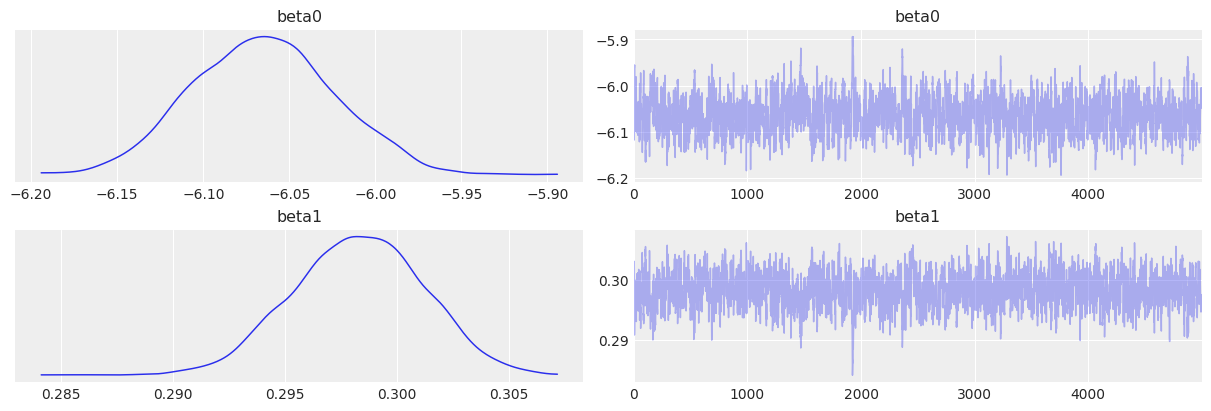

In [ ]:
az.plot_trace(idata)

In [ ]:
with model:
    pm.set_data({'X': df_test.X,
                 'y': df_test.y})
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=RANDOM_SEED)

In [ ]:
idata.to_netcdf('{}/2021_idata.nc'.format(path))

'/content/drive/Othercomputers/My MacBook Air/thesis/model/2021_idata.nc'